# Voorbereiding

In [1]:
import os
import json
import asyncio

import traitlets

import numpy as np
import pandas as pd

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual, Layout

import time
from datetime import datetime

from storingsanalyse import StoringsAnalyse

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from IPython.display import Markdown, Latex

In [2]:
class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))


# Aparte functie voor het wachten op verandering (aka input van de ME)
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

In [3]:
""" In the line bellow fill in your API key without < and > """ 
api_key = 'bWF4YWRtaW46R21iQ1dlbkQyMDE5' # provided to you by a Maximo Consultant

""" In the line bellow fill in the desired object structure """
obj_struct = 'MXWO_SND' # name of the Maximo object structure

""" In the line bellow fill in the PO number and the SITEID without the < and > """
query = 'siteid="CT1EN2" and worktype="COR" and reportdate>="2018-01-01T00:00:00-00:00" and reportdate<="2018-03-30T00:00:00-00:00"'

In [4]:
sa = StoringsAnalyse("coentunnel", api_key)

In [5]:
sa.read_staging_file("20210702_12_55_staging_file.xlsx")

C:\Users\NBais\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [6]:
sf_data = sa.staging_file_data

### Aanpassen van de staging_file -- DEZE STAP WORDT VERWIJDERD IN DE TOEKOMST
Het opbouwen van deze automatische storingsanalyse vraagt om een ingevulde kolom 'type melding'. Om het process van opbouwen niet te laten stagneren op dit aspect, wordt er hieronder fictive data gegenereerd. Met behulp van de fictieve data wordt het genereren van de verschillende tabellen en grafieken gebouwd.

In [7]:
from random import randrange

lijst_opties = ['Storing', 'Incident', 'Preventief', 'Onterecht']
random_ranges = [lijst_opties[randrange(0, 4, 1)] for _ in range(len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))]
sf_data.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'] = random_ranges

In [8]:
lijst_opties = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', np.nan]
random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['probleem code']))]
sf_data.loc[:, 'probleem code'] = random_ranges

In [9]:
lijst_opties = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', np.nan]
random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oorzaak code']))]
sf_data.loc[:, 'oorzaak code'] = random_ranges

In [10]:
lijst_opties = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', np.nan]
random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oplos code']))]
sf_data.loc[:, 'oplos code'] = random_ranges

In [11]:
# sf_data.iloc[:5, 15:25]

In [12]:
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in sf_data['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

sf_data.loc[:, 'sbs'] = new_num

In [13]:
# sf_data.iloc[:5, 5:15]

In [14]:
sa.split_staging_file()

'Data available through the use of StoringsAnalyse.meldingen and StoringsAnalyse.storingen'

# Analyse

## Aantallen meldingen

### Aantal meldingen per maand

In [15]:
# Data voor in tekst ophalen
totaal_aantal_meldingen = len(sf_data.index)

meldingen_per_maand = sf_data['month_number'].value_counts()

gemiddelde_per_maand = sum(meldingen_per_maand) / len(meldingen_per_maand)

num_maand_max_meldingen = [meldingen_per_maand.index[meldingen_per_maand == max(meldingen_per_maand)][0]]
maand_max = sa._month_num_to_name(month_num=num_maand_max_meldingen)

num_maand_min_meldingen = [meldingen_per_maand.index[meldingen_per_maand == min(meldingen_per_maand)][0]]
maand_min = sa._month_num_to_name(month_num=num_maand_min_meldingen)

data_2019 = [key for key in sa.metadata.meldingen().keys() if '2019' in key]
meldingen_2019 = sa.metadata.sum_values(dictionary=sa.meldingen, keys=data_2019)

jaarlijks_gemiddelde = sa.metadata.avg_yearly(dictionary=sa.metadata.meldingen(), exclude_year='2020')

maanden = sa.metadata.get_month_list(exclude_year='2020')
maandelijks_gemiddelde = sa.metadata.avg_monthly(dictionary=sa.metadata.meldingen(), exclude_keys=maanden)

kwartaal_gemiddelde = sa.metadata.avg_quarterly(dictionary=sa.metadata.meldingen())

# tekst opbouwen + afbeelden 
tekst = f"""
Om te kunnen bepalen of een trend waarneembaar is in het aantal meldingen per 
maand, wordt als onderdeel van deze rapportage een grafiek toegevoegd. Zie 
bijlage 1: “Aantal meldingen per maand”.

Uit de grafiek valt het volgende te constateren:

• Het totaal aantal meldingen in Q1 2021 : **{totaal_aantal_meldingen}** 

• Het gemiddelde aantal meldingen per maand : **{gemiddelde_per_maand}** 

• Hoogste aantal meldingen in de maand **{maand_max}** : **{max(meldingen_per_maand)}**

• Laagste aantal meldingen in de maanden **{maand_min}** : **{min(meldingen_per_maand)}**

• Het gemiddelde aantal meldingen per maand vanaf **{sa.start_date}**: **{maandelijks_gemiddelde}**

• Het gemiddelde aantal meldingen per kwartaal vanaf **{sa.start_date}**: **{kwartaal_gemiddelde}**
"""
display(Markdown(tekst))


Om te kunnen bepalen of een trend waarneembaar is in het aantal meldingen per 
maand, wordt als onderdeel van deze rapportage een grafiek toegevoegd. Zie 
bijlage 1: “Aantal meldingen per maand”.

Uit de grafiek valt het volgende te constateren:

• Het totaal aantal meldingen in Q1 2021 : **99** 

• Het gemiddelde aantal meldingen per maand : **33.0** 

• Hoogste aantal meldingen in de maand **Februari** : **45**

• Laagste aantal meldingen in de maanden **Maart** : **24**

• Het gemiddelde aantal meldingen per maand vanaf **01-2016**: **35.98412698412698**

• Het gemiddelde aantal meldingen per kwartaal vanaf **01-2016**: **107.95238095238095**


In [16]:
huidige_q = 'Q1'
huidig_jaar = '2021'

# Aantal meldingen in voorgaande q
voorgaande_q = sa.quarter_sequence.get_prev_val(huidige_q)
voorgaand_jaar = str(int(huidig_jaar) - 1)
mlist = sa.metadata.get_keys(dictionary=sa.metadata.meldingen(), containing_quarter=[voorgaande_q], containing_year=[voorgaand_jaar])
meldingen_gefilterd = sa.metadata.filter_dictionary_keys(dictionary=sa.metadata.meldingen(), keys=mlist)
totaal_meldingen_voorgaand_kwartaal = sa.metadata.sum_values(meldingen_gefilterd)

# Aantal meldingen in zelfde q voorgaand jaar
mlist = sa.metadata.get_keys(dictionary=sa.metadata.meldingen(),containing_quarter=[huidige_q], containing_year=[voorgaand_jaar])
meldingen_gefilterd = sa.metadata.filter_dictionary_keys(dictionary=sa.metadata.meldingen(), keys=mlist)
totaal_meldingen_zelfde_kwartaal = sa.metadata.sum_values(meldingen_gefilterd)

tekst = f"""
In **{huidige_q}** **{voorgaand_jaar}** waren in totaal **{totaal_meldingen_zelfde_kwartaal}** meldingen gemaakt. In **{huidige_q}** **{huidig_jaar}** zijn er **{totaal_aantal_meldingen-totaal_meldingen_zelfde_kwartaal}** meldingen 
meer t.o.v. **{huidige_q}** **{voorgaand_jaar}**. 
 
In **{voorgaande_q}** **{voorgaand_jaar}** waren in totaal **{totaal_meldingen_voorgaand_kwartaal}** meldingen gemaakt. In **{huidige_q}** **{huidig_jaar}** zijn er **{totaal_aantal_meldingen-totaal_meldingen_voorgaand_kwartaal}** meldingen 
meer t.o.v. **{voorgaande_q}** **{voorgaand_jaar}**. 
"""
display(Markdown(tekst))


In **Q1** **2020** waren in totaal **60** meldingen gemaakt. In **Q1** **2021** zijn er **39** meldingen 
meer t.o.v. **Q1** **2020**. 
 
In **Q4** **2020** waren in totaal **79** meldingen gemaakt. In **Q1** **2021** zijn er **20** meldingen 
meer t.o.v. **Q4** **2020**. 


### Aantal meldingen per subsysteem 

In [17]:
df = sa.meldingen.copy()
# unieke types vastlegen
unique_types = list(df.loc[:, 'sbs'].unique())

sbs_count = df.loc[:, 'sbs'].value_counts()

input_threshhold = widgets.IntSlider(
    value=3,
    min=sbs_count.min(),
    max=sbs_count.max(),
    step=1,
    description='Drempelwaarde:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=dict(description_width='initial')
)

display(input_threshhold)

IntSlider(value=3, continuous_update=False, description='Drempelwaarde:', max=10, min=1, style=SliderStyle(des…

In [18]:
# sbs nummers die verwerkt moeten worden
sbs_to_process = [x for x in sbs_count.index if sbs_count.at[x] >= input_threshhold.value]

# lijst met rijen die verwerkt moeten worden
rows2process = list()
for sbs in sbs_to_process:
    meldingen_per_sbs = sbs_count[sbs]
    percentage_storing = round((meldingen_per_sbs / sum(sbs_count)) * 100, 2)
    line = f"{sa._get_breakdown_description(sbs)}\t- {meldingen_per_sbs} meldingen ({percentage_storing}% van het totale aantal meldingen)"
    rows2process.append(line)

# notification type
ntypes = list(df.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'].unique())
ntype_count = df.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'].value_counts()
n2p = list()
for n in ntypes:
    line = f"{ntype_count[n]} meldingen zijn gecategoriseerd als {n}."
    n2p.append(line)

# '\' is not allowed as character in a f-string like bellow. reason for newline and tab
newline = '\n'
tab = '\t'

tekst=f"""
Er wordt en Pareto analyse gemaakt van het totaal aantal meldingen per subsysteem. Deze is toegevoegd als bijlage 1. 
 
Uit de pareto blijkt dat in **{huidige_q}** **{voorgaand_jaar}** een totaal van **{totaal_aantal_meldingen}** meldingen zijn gemeld, intern 
dan wel extern. Voor het overzicht zijn de meldingen bekeken met **{input_threshhold.value}** of meer 
meldingen. Dit is de top **{len(sbs_to_process)}** en heeft een totaal van **{sum(sbs_count[sbs_to_process])}** meldingen van de in totaal 
**{totaal_aantal_meldingen}** (dit is **{round((sum(sbs_count[sbs_to_process])/totaal_aantal_meldingen) * 100, 2)}**% van het totaal). 
Hieronder staan de deelinstallatie**{'s' if len(sbs_to_process) > 1 else ''}**:


{''.join((newline + '**-' + tab + line + '**' + newline for line in rows2process))}


De **{totaal_aantal_meldingen}** van **{huidige_q}** **{huidig_jaar}** zijn als volgt onder te verdelen:

{''.join((newline + '**-' + tab + ntype_line + '**' + newline for ntype_line in n2p))}

"""
display(Markdown(tekst))


Er wordt en Pareto analyse gemaakt van het totaal aantal meldingen per subsysteem. Deze is toegevoegd als bijlage 1. 
 
Uit de pareto blijkt dat in **Q1** **2020** een totaal van **99** meldingen zijn gemeld, intern 
dan wel extern. Voor het overzicht zijn de meldingen bekeken met **3** of meer 
meldingen. Dit is de top **4** en heeft een totaal van **26** meldingen van de in totaal 
**99** (dit is **26.26**% van het totaal). 
Hieronder staan de deelinstallatie**s**:



**-	Afsluitbomen (AB)	- 10 meldingen (23.26% van het totale aantal meldingen)**

**-	Verkeerssignaleringssysteem (MTM)	- 7 meldingen (16.28% van het totale aantal meldingen)**

**-	Calamiteiten doorsteek (CaDo)	- 5 meldingen (11.63% van het totale aantal meldingen)**

**-	Brandmeldinstallatie dienstengebouwen	- 4 meldingen (9.3% van het totale aantal meldingen)**



De **99** van **Q1** **2021** zijn als volgt onder te verdelen:


**-	26 meldingen zijn gecategoriseerd als Preventief.**

**-	22 meldingen zijn gecategoriseerd als Onterecht.**

**-	31 meldingen zijn gecategoriseerd als Incident.**

**-	20 meldingen zijn gecategoriseerd als Storing.**




## Aantallen storingen

### Aantal storingen per maand

In [19]:
totaal_aantal_storingen = len(sf_data.index)

storingen_per_maand = sf_data['month_number'].value_counts()

gemiddelde_per_maand = sum(storingen_per_maand) / len(storingen_per_maand)

num_maand_max_storingen = [storingen_per_maand.index[storingen_per_maand == max(storingen_per_maand)][0]]
maand_max = sa._month_num_to_name(month_num=num_maand_max_storingen)

num_maand_min_storingen = [storingen_per_maand.index[storingen_per_maand == min(storingen_per_maand)][0]]
maand_min = sa._month_num_to_name(month_num=num_maand_min_storingen)

data_2019 = [key for key in sa.metadata.storingen().keys() if '2019' in key]
storingen_2019 = sa.metadata.sum_values(dictionary=sa.storingen, keys=data_2019)

jaarlijks_gemiddelde = sa.metadata.avg_yearly(dictionary=sa.metadata.storingen(), exclude_year='2020')

maanden = sa.metadata.get_month_list(exclude_year='2020')
maandelijks_gemiddelde = sa.metadata.avg_monthly(dictionary=sa.metadata.storingen(), exclude_keys=maanden)

kwartaal_gemiddelde = sa.metadata.avg_quarterly(dictionary=sa.metadata.storingen())

# Tekst opbouwen + afbeelden
tekst = f"""
Om te kunnen bepalen of een trend waarneembaar is in het aantal storingen per 
maand, wordt als onderdeel van deze rapportage een grafiek toegevoegd. Zie 
bijlage 1: “Aantal storingen per maand”.

Uit de grafiek valt het volgende te constateren:

• Het totaal aantal storingen in Q1 2021 : **{totaal_aantal_storingen}**

• Het gemiddelde aantal storingen per maand : **{gemiddelde_per_maand}**

• Hoogste aantal storingen in de maand **{maand_max}** : **{max(storingen_per_maand)}**

• Laagste aantal storingen in de maanden **{maand_min}** : **{min(storingen_per_maand)}**

• Het gemiddelde aantal storingen per maand vanaf **{sa.start_date}**: **{maandelijks_gemiddelde}**

• Het gemiddelde aantal storingen per kwartaal vanaf **{sa.start_date}**: **{kwartaal_gemiddelde}**
"""
display(Markdown(tekst))


Om te kunnen bepalen of een trend waarneembaar is in het aantal storingen per 
maand, wordt als onderdeel van deze rapportage een grafiek toegevoegd. Zie 
bijlage 1: “Aantal storingen per maand”.

Uit de grafiek valt het volgende te constateren:

• Het totaal aantal storingen in Q1 2021 : **99**

• Het gemiddelde aantal storingen per maand : **33.0**

• Hoogste aantal storingen in de maand **Februari** : **45**

• Laagste aantal storingen in de maanden **Maart** : **24**

• Het gemiddelde aantal storingen per maand vanaf **01-2016**: **19.19047619047619**

• Het gemiddelde aantal storingen per kwartaal vanaf **01-2016**: **57.57142857142857**


In [20]:
huidige_q = 'Q1'
huidig_jaar = '2021'

# Aantal storingen in voorgaande q
voorgaande_q = sa.quarter_sequence.get_prev_val(huidige_q)
voorgaand_jaar = str(int(huidig_jaar) - 1)
mlist = sa.metadata.get_keys(dictionary=sa.metadata.storingen(), containing_quarter=[voorgaande_q], containing_year=[voorgaand_jaar])
storingen_gefilterd = sa.metadata.filter_dictionary_keys(dictionary=sa.metadata.storingen(), keys=mlist)
totaal_storingen_voorgaand_kwartaal = sa.metadata.sum_values(storingen_gefilterd)

# Aantal storingen in zelfde q voorgaand jaar
mlist = sa.metadata.get_keys(dictionary=sa.metadata.storingen(),containing_quarter=[huidige_q], containing_year=[voorgaand_jaar])
storingen_gefilterd = sa.metadata.filter_dictionary_keys(dictionary=sa.metadata.storingen(), keys=mlist)
totaal_storingen_zelfde_kwartaal = sa.metadata.sum_values(storingen_gefilterd)

tekst = f"""
In **{huidige_q}** **{voorgaand_jaar}** waren in totaal **{totaal_storingen_zelfde_kwartaal}** storingen gemaakt. In **{huidige_q}** **{huidig_jaar}** zijn er **{totaal_aantal_storingen - totaal_storingen_zelfde_kwartaal}** storingen 
meer t.o.v. **{huidige_q}** **{voorgaand_jaar}**. 

In **{voorgaande_q}** **{voorgaand_jaar}** waren in totaal **{totaal_storingen_voorgaand_kwartaal}** storingen gemaakt. In **{huidige_q}** **{huidig_jaar}** zijn er **{totaal_aantal_storingen - totaal_storingen_voorgaand_kwartaal}** storingen 
meer t.o.v. **{voorgaande_q}** **{voorgaand_jaar}**. 
"""
display(Markdown(tekst))


In **Q1** **2020** waren in totaal **31** storingen gemaakt. In **Q1** **2021** zijn er **68** storingen 
meer t.o.v. **Q1** **2020**. 

In **Q4** **2020** waren in totaal **39** storingen gemaakt. In **Q1** **2021** zijn er **60** storingen 
meer t.o.v. **Q4** **2020**. 


### Aantal storingen per subsysteem

In [21]:
df = sa.storingen.copy()
# unieke types vastlegen
unique_types = list(df.loc[:, 'sbs'].unique())

sbs_count = df.loc[:, 'sbs'].value_counts()

sbs_to_process = [x for x in sbs_count.index if sbs_count.at[x] >= input_threshhold.value]

r2p = list()
for sbs in sbs_to_process:
    storingen_per_sbs = sbs_count[sbs]
    percentage_storing = round((storingen_per_sbs / sum(sbs_count)) * 100, 2)
    line = f"{sa._get_breakdown_description(sbs)}\t- {storingen_per_sbs} storingen ({percentage_storing}% van het totale aantal storingen)"
    r2p.append(line)

# '\' is not allowed as character in a f-string like bellow. reason for newline and tab
newline = '\n'
tab = '\t'

tekst = f"""
Er wordt en Pareto analyse gemaakt van het totaal aantal storingen per subsysteem. Deze is toegevoegd als bijlage. 

Uit de pareto blijkt dat in **{huidige_q}** **{huidig_jaar}** een totaal van **{totaal_aantal_storingen}** storingen zijn gemeld, intern 
dan wel extern. Voor het overzicht zijn de storingen bekeken met **{input_threshhold.value}** of meer 
storingen. Dit is de top **{len(sbs_to_process)}** en heeft een totaal van **{sum(sbs_count[sbs_to_process])}** storingen van de in totaal 
**{totaal_aantal_storingen}** (dit is **{round((sum(sbs_count[sbs_to_process]) / totaal_aantal_storingen) * 100, 2)}**% van het totaal). 
Hieronder staan de deelinstallatie**{'s' if len(sbs_to_process) > 1 else ''}**:

{''.join((newline + '**-' + tab + line + '**' + newline for line in r2p))}

In totaal hebben **{len(sbs_count)}** deelsystemen **{min(sbs_count)}** of meerdere storingen gehad in **{huidige_q}** **{huidig_jaar}**.

"""
display(Markdown(tekst))


Er wordt en Pareto analyse gemaakt van het totaal aantal storingen per subsysteem. Deze is toegevoegd als bijlage. 

Uit de pareto blijkt dat in **Q1** **2021** een totaal van **99** storingen zijn gemeld, intern 
dan wel extern. Voor het overzicht zijn de storingen bekeken met **3** of meer 
storingen. Dit is de top **0** en heeft een totaal van **0** storingen van de in totaal 
**99** (dit is **0.0**% van het totaal). 
Hieronder staan de deelinstallatie****:



In totaal hebben **10** deelsystemen **1** of meerdere storingen gehad in **Q1** **2021**.



# Conclusie / aanbeveling

## Algemeen

In [22]:
sbs_count = df.loc[:, 'sbs'].value_counts(dropna=False)

tekst = f"""
Er heeft een analyse van de storingen plaatsgevonden. Uit deze analyse is niet 
naar voren gekomen dat verbeteren aan het onderhoudsplan en/of procedures en/of 
hardware noodzakelijk zijn om het faalgedrag te verbeteren. 
 
Alle meldingen moeten aan een asset / sub niveau van een DI worden gekoppeld. 
Zodat altijd is te herleiden wat precies is gefaald. Aan alle meldingen is DI 
gekoppeld. Aan **{max(sbs_count[sbs_count.index.isnull()].values)}** werkorders zit geen asset gekoppeld. (zie besluit 5). 
 
De meldingen zijn gekoppeld aan een probleem, oorzaak en oplossing. 
 
Vanaf 1 september 2018 heeft een update plaats gevonden van het 
onderhoudsmanagementsysteem. Bij deze update is het invullen van probleem, 
oorzaak en oplossing toegevoegd in het systeem. Vanaf Q4 2018 zal dit ook 
worden meegenomen in de analyse. In de volgende paragrafen staat de uitwerking 
hiervan. Daarbij zie je het aantal van het huidige jaar, het totaal aantal en het 
gemiddelde per Q vanaf Q4 2018.
"""
display(Markdown(tekst))


Er heeft een analyse van de storingen plaatsgevonden. Uit deze analyse is niet 
naar voren gekomen dat verbeteren aan het onderhoudsplan en/of procedures en/of 
hardware noodzakelijk zijn om het faalgedrag te verbeteren. 
 
Alle meldingen moeten aan een asset / sub niveau van een DI worden gekoppeld. 
Zodat altijd is te herleiden wat precies is gefaald. Aan alle meldingen is DI 
gekoppeld. Aan **9** werkorders zit geen asset gekoppeld. (zie besluit 5). 
 
De meldingen zijn gekoppeld aan een probleem, oorzaak en oplossing. 
 
Vanaf 1 september 2018 heeft een update plaats gevonden van het 
onderhoudsmanagementsysteem. Bij deze update is het invullen van probleem, 
oorzaak en oplossing toegevoegd in het systeem. Vanaf Q4 2018 zal dit ook 
worden meegenomen in de analyse. In de volgende paragrafen staat de uitwerking 
hiervan. Daarbij zie je het aantal van het huidige jaar, het totaal aantal en het 
gemiddelde per Q vanaf Q4 2018.


### Probleem

In [23]:
probleem_code_count = sf_data['probleem code'].value_counts(dropna=False).to_dict()
oorzaak_code_count = sf_data['oorzaak code'].value_counts(dropna=False).to_dict()
oplossing_code_count = sf_data['oplos code'].value_counts(dropna=False).to_dict()

meta_probleem = sa.metadata.poo_data()['probleem']
meta_oorzaak = sa.metadata.poo_data()['oorzaak']
meta_oplossing = sa.metadata.poo_data()['oplossing']

poo_beschrijvingen = sa.metadata.contract_info()['POO_codes']

probleem_code_count['Leeg'] = probleem_code_count.pop(np.nan)
oorzaak_code_count['Leeg'] = oorzaak_code_count.pop(np.nan)
oplossing_code_count['Leeg'] = oplossing_code_count.pop(np.nan)

probleem_avg_table = sa.metadata.poo_avg_table(meta_probleem)
oorzaak_avg_table = sa.metadata.poo_avg_table(meta_oorzaak)
oplossing_avg_table = sa.metadata.poo_avg_table(meta_oplossing)

In [24]:
line_dict = dict()
for code in (k for k in poo_beschrijvingen.keys() if 'P' in k or k == 'Leeg'):    
    code_counts = list()
    for q in meta_probleem.keys():
        if code in meta_probleem[q].keys():
            code_counts.append(sa.metadata.sum_values(dictionary=meta_probleem[q], keys=[code]))
        else:
            code_counts.append(0)
    
    totaal = sum(code_counts)
    
    if code not in probleem_avg_table.keys():
        line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(probleem_code_count[code]) + '|' + str(totaal) + '|' + '0' + '|'))
        line_dict[code] = line
        continue
    
    line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(probleem_code_count[code]) + '|' + str(totaal) + '|' + str(probleem_avg_table[code]) + '|'))
    line_dict[code] = line
    
tekst = f"""
|Probleem|Beschrijving|Aantal|Totaal|Gemiddelde|
|--------|------------|------|------|----------|{''.join((line_dict[code] for code in line_dict.keys()))}
"""
display(Markdown(tekst))


|Probleem|Beschrijving|Aantal|Totaal|Gemiddelde|
|--------|------------|------|------|----------|
|P01|Niet beschikbaar|11|107|10.7|
|P02|Geen / slecht / afwijkend beeld|9|54|5.4|
|P03|Aangereden|5|44|4.4|
|P04|In storing|6|118|11.8|
|P05|Blijft hangen|10|33|3.3|
|P06|Fatale fout|9|25|2.5|
|P07|Gewenste stand komt niet overeen (niet mogelijk)|4|9|0.9|
|P08|Geen communicatie (mogelijk)|11|10|1.0|
|P09|Oproep actief|10|3|0.3|
|P10|Niet bedienbaar|7|17|1.7|
|P11|Overige|9|233|23.3|
|Leeg|Niet ingevuld|8|162|16.2|


### Oorzaak

In [25]:
line_dict = dict()
for code in (k for k in poo_beschrijvingen.keys() if 'C' in k or k == 'Leeg'):   
    code_counts = list()
    for q in meta_oorzaak.keys():
        if code in meta_oorzaak[q].keys():
            code_counts.append(sa.metadata.sum_values(dictionary=meta_oorzaak[q], keys=[code]))
        else:
            code_counts.append(0)
    
    totaal = sum(code_counts)
    
    if code not in oorzaak_avg_table.keys():
        line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(oorzaak_code_count[code]) + '|' + str(totaal) + '|' + '0' + '|'))
        line_dict[code] = line
        continue
    
    line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(oorzaak_code_count[code]) + '|' + str(totaal) + '|' + str(oorzaak_avg_table[code]) + '|'))
    line_dict[code] = line

tekst = f"""
|Oorzaak|Beschrijving|Aantal|Totaal|Gemiddelde|
|-------|------------|------|------|----------|{''.join((line_dict[code] for code in line_dict.keys()))}
"""
display(Markdown(tekst))


|Oorzaak|Beschrijving|Aantal|Totaal|Gemiddelde|
|-------|------------|------|------|----------|
|Leeg|Niet ingevuld|8|180|18.0|
|C01|Corrosie|2|4|0.4|
|C02|Mechanische slijtage, - breuk, - vervorming|5|14|1.4|
|C03|Molest / diefstal|4|3|0.3|
|C04|Ongedierte|7|0|0|
|C05|Schade|5|12|1.2|
|C06|Random / software / applicatie fout|6|41|4.1|
|C07|Thermische vervorming|5|2|0.2|
|C08|Veroudering|9|99|9.9|
|C09|Vervuiling|4|7|0.7|
|C10|Weersomstandigheden|7|38|3.8|
|C11|Externe oorzaak|9|42|4.2|
|C12|Aanlegkwaliteit|4|3|0.3|
|C13|Overige|4|309|30.9|
|C14|Bedienfout|7|20|2.0|
|C15|Vocht|5|3|0.3|
|C16|Incident|8|35|3.5|


### Oplossing

In [26]:
line_dict = dict()
for code in (k for k in poo_beschrijvingen.keys() if 'S' in k or k == 'Leeg'):
    code_counts = list()
    for q in meta_oplossing.keys():
        if code in meta_oplossing[q].keys():
            code_counts.append(sa.metadata.sum_values(dictionary=meta_oplossing[q], keys=[code]))
        else:
            code_counts.append(0)

    totaal = sum(code_counts)
    
    if code not in oplossing_avg_table.keys():
        line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(oplossing_code_count[code]) + '|' + str(totaal) + '|' + str(oplossing_avg_table[code]) + '|'))
        line_dict[code] = line
        continue
        
    line = ''.join((newline + '|' + code + '|' + poo_beschrijvingen[code] + '|' + str(oplossing_code_count[code]) + '|' + str(totaal) + '|' + str(oplossing_avg_table[code]) + '|'))
    line_dict[code] = line

tekst = f"""
|Oplossing|Beschrijving|Aantal|Totaal|Gemiddelde|
|---------|------------|------|------|----------|{''.join((line_dict[code] for code in line_dict.keys()))}
"""
display(Markdown(tekst))


|Oplossing|Beschrijving|Aantal|Totaal|Gemiddelde|
|---------|------------|------|------|----------|
|Leeg|Niet ingevuld|9|180|18.0|
|S01|Reinigen|13|10|1.0|
|S02|Vervangen|8|244|24.4|
|S03|Resetten|11|173|17.3|
|S04|Afstellen/vastzetten|10|24|2.4|
|S05|Bijvullen|15|2|0.2|
|S06|Repareren|11|11|1.1|
|S07|Smeren / bijvullen / bijwerken|10|2|0.2|
|S08|Overige|12|166|16.6|


## Storingen per deelinstallatie uitgewerkt

In [27]:
df = sa.meldingen.copy()
# unieke types vastlegen
unique_types = list(df.loc[:, 'sbs'].unique())

sbs_count = df.loc[:, 'sbs'].value_counts()

input_threshhold = widgets.IntSlider(
    value=3,
    min=sbs_count.min(),
    max=sbs_count.max(),
    step=1,
    description='Drempelwaarde:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=dict(description_width='initial')
)

display(input_threshhold)

IntSlider(value=3, continuous_update=False, description='Drempelwaarde:', max=10, min=1, style=SliderStyle(des…

In [28]:
# prep
_group_data_to_print = dict()

sf_data_groupby_sbs = sf_data.groupby('sbs')

for group in sf_data_groupby_sbs.groups:
    group_data = sf_data_groupby_sbs.get_group(group).copy()
    
    totaal_aantal_storingen = len(group_data.index)
    if totaal_aantal_storingen < input_threshhold.value:
        continue

    storingen_per_maand = group_data['month_number'].value_counts()

    gemiddelde_per_maand = sum(storingen_per_maand) / len(storingen_per_maand)

    num_maand_max_storingen = [storingen_per_maand.index[storingen_per_maand == max(storingen_per_maand)][0]]
    maand_max = sa._month_num_to_name(month_num=num_maand_max_storingen)

    num_maand_min_storingen = [storingen_per_maand.index[storingen_per_maand == min(storingen_per_maand)][0]]
    maand_min = sa._month_num_to_name(month_num=num_maand_min_storingen)

    data_2019 = [key for key in sa.metadata.storingen().keys() if '2019' in key]
    storingen_2019 = sa.metadata.sum_values(dictionary=sa.storingen, keys=data_2019)

    jaarlijks_gemiddelde = sa.metadata.avg_yearly(dictionary=sa.metadata.storingen(), exclude_year='2020')

    maanden = sa.metadata.get_month_list(exclude_year='2020')
    maandelijks_gemiddelde = sa.metadata.avg_monthly(dictionary=sa.metadata.storingen(), exclude_keys=maanden)

    kwartaal_gemiddelde = sa.metadata.avg_quarterly(dictionary=sa.metadata.storingen())
    
    data_to_print = {"totaal_aantal_storingen": totaal_aantal_storingen,
                     "gemiddelde_per_maand": gemiddelde_per_maand,
                     "maand_max": maand_max,
                     "maand_min": maand_min,
                     "max_storingen_per_maand": max(storingen_per_maand),
                     "min_storingen_per_maand":  min(storingen_per_maand),
                     "maandelijks_gemiddelde_start_project": maandelijks_gemiddelde,
                     "kwartaal_gemiddelde": kwartaal_gemiddelde,
                     "start_date": sa.start_date}
    
    _group_data_to_print[group] = data_to_print

sorted_keys = sorted(_group_data_to_print, key=lambda item: _group_data_to_print[item]['totaal_aantal_storingen'], reverse=True)
group_data_to_print = {key: _group_data_to_print[key] for key in sorted_keys}

# print
texts2print = []

for group, data in group_data_to_print.items():   
    _tekst = f"""
    # {str(group)}
    Hieronder is een vergelijking gemaakt van het aantal storingen van deelinstallatie {group}
    t.o.v. andere kwartalen (hetzelfde kwartaal van vorig jaar en vorig kwartaal) en t.o.v. 
    het gemiddelde vanaf **{data["start_date"]}**. 

    Uit de grafiek valt het volgende te constateren:

    • Het totaal aantal storingen in Q1 2021 : **{data["totaal_aantal_storingen"]}**

    • Het gemiddelde aantal storingen per maand : **{data["gemiddelde_per_maand"]}**

    • Hoogste aantal storingen in de maand **{data["maand_max"]}** : **{data["max_storingen_per_maand"]}**

    • Laagste aantal storingen in de maanden **{data["maand_min"]}** : **{data["min_storingen_per_maand"]}**

    • Het gemiddelde aantal storingen per maand vanaf **{data["start_date"]}**: **{data["maandelijks_gemiddelde_start_project"]}**

    • Het gemiddelde aantal storingen per kwartaal vanaf **{data["start_date"]}**: **{data["kwartaal_gemiddelde"]}**{newline}
    """
    texts2print.append(_tekst)

tekst = f"""
{''.join((t for t in texts2print))}
"""
display(Markdown(tekst))



    # 45
    Hieronder is een vergelijking gemaakt van het aantal storingen van deelinstallatie 45
    t.o.v. andere kwartalen (hetzelfde kwartaal van vorig jaar en vorig kwartaal) en t.o.v. 
    het gemiddelde vanaf **01-2016**. 

    Uit de grafiek valt het volgende te constateren:

    • Het totaal aantal storingen in Q1 2021 : **10**

    • Het gemiddelde aantal storingen per maand : **3.3333333333333335**

    • Hoogste aantal storingen in de maand **Februari** : **4**

    • Laagste aantal storingen in de maanden **Januari** : **3**

    • Het gemiddelde aantal storingen per maand vanaf **01-2016**: **19.19047619047619**

    • Het gemiddelde aantal storingen per kwartaal vanaf **01-2016**: **57.57142857142857**

    
    # 41
    Hieronder is een vergelijking gemaakt van het aantal storingen van deelinstallatie 41
    t.o.v. andere kwartalen (hetzelfde kwartaal van vorig jaar en vorig kwartaal) en t.o.v. 
    het gemiddelde vanaf **01-2016**. 

    Uit de grafiek valt het volgende te constateren:

    • Het totaal aantal storingen in Q1 2021 : **7**

    • Het gemiddelde aantal storingen per maand : **2.3333333333333335**

    • Hoogste aantal storingen in de maand **Januari** : **4**

    • Laagste aantal storingen in de maanden **Maart** : **1**

    • Het gemiddelde aantal storingen per maand vanaf **01-2016**: **19.19047619047619**

    • Het gemiddelde aantal storingen per kwartaal vanaf **01-2016**: **57.57142857142857**

    
    # 46A
    Hieronder is een vergelijking gemaakt van het aantal storingen van deelinstallatie 46A
    t.o.v. andere kwartalen (hetzelfde kwartaal van vorig jaar en vorig kwartaal) en t.o.v. 
    het gemiddelde vanaf **01-2016**. 

    Uit de grafiek valt het volgende te constateren:

    • Het totaal aantal storingen in Q1 2021 : **5**

    • Het gemiddelde aantal storingen per maand : **2.5**

    • Hoogste aantal storingen in de maand **Februari** : **4**

    • Laagste aantal storingen in de maanden **Maart** : **1**

    • Het gemiddelde aantal storingen per maand vanaf **01-2016**: **19.19047619047619**

    • Het gemiddelde aantal storingen per kwartaal vanaf **01-2016**: **57.57142857142857**

    
    # 74
    Hieronder is een vergelijking gemaakt van het aantal storingen van deelinstallatie 74
    t.o.v. andere kwartalen (hetzelfde kwartaal van vorig jaar en vorig kwartaal) en t.o.v. 
    het gemiddelde vanaf **01-2016**. 

    Uit de grafiek valt het volgende te constateren:

    • Het totaal aantal storingen in Q1 2021 : **4**

    • Het gemiddelde aantal storingen per maand : **2.0**

    • Hoogste aantal storingen in de maand **Februari** : **3**

    • Laagste aantal storingen in de maanden **Maart** : **1**

    • Het gemiddelde aantal storingen per maand vanaf **01-2016**: **19.19047619047619**

    • Het gemiddelde aantal storingen per kwartaal vanaf **01-2016**: **57.57142857142857**

    


# Assets met de meeste meldingen

## Algemeen

In [29]:
meldingen_per_asset = sf_data['asset nummer'].value_counts()
meldingen_per_asset = meldingen_per_asset.reset_index()
meldingen_per_asset.rename(columns={"asset nummer": "count", "index": "asset nummer"}, inplace=True)

list_descriptions = {sf_data['asset nummer'][index]: sf_data['asset beschrijving'][index] for index in range(sf_data.shape[0])} 


asset_beschrijvingen = []
for index, row in meldingen_per_asset.iterrows():
    asset_num = row[0]
    if asset_num in list_descriptions.keys():
        asset_beschrijvingen.append(list_descriptions[asset_num])

meldingen_per_asset.at[:, 'asset beschrijving'] = asset_beschrijvingen

# ophalen van de sbs nummers van de assets
sbs_dict = dict()
for asset_num in meldingen_per_asset.loc[:, 'asset nummer'].to_dict().values():
    row = sf_data[sf_data.loc[:, 'asset nummer'] == asset_num]
    sbs_dict[asset_num] = row['sbs'].unique()[0]

In [30]:
input_threshhold = widgets.IntSlider(
    value=3,  # meldingen_per_asset['count'].min()
    min=meldingen_per_asset['count'].min(),
    max=meldingen_per_asset['count'].max(),
    step=1,
    description='Drempelwaarde:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=dict(description_width='initial')
)

display(input_threshhold)

IntSlider(value=3, continuous_update=False, description='Drempelwaarde:', max=4, min=1, style=SliderStyle(desc…

In [31]:
lines = list()
lines2handle = meldingen_per_asset[meldingen_per_asset['count'] >= input_threshhold.value]
for r in lines2handle.iterrows():
    row = r[1]
    line = ''.join((newline + '|' + str(sa._get_breakdown_description(sbs_dict[row[0]])) + '|' + str(row[-1]) + '|' + str(row[1]) + '|'))
    lines.append(line)
    
tekst = f"""
De hieronder benoemde assets, zijn de **{len(lines)}** assets die **{input_threshhold.value}** of meer meldingen hebben 
gehad in **{huidige_q}** **{huidig_jaar}**: 

|Deelinstallatie|Asset|Aantal|
|---------------|-----|------|{''.join((line for line in lines))}
"""
display(Markdown(tekst))


De hieronder benoemde assets, zijn de **2** assets die **3** of meer meldingen hebben 
gehad in **Q1** **2021**: 

|Deelinstallatie|Asset|Aantal|
|---------------|-----|------|
|Calamiteiten doorsteek (CaDo)|A10 CADO 29,280 BBR (CB) - CADO boom|4|
|Verkeerssignaleringssysteem (MTM)|A10 TSG2 30,015PWn - Kast A10 TSG2 30,015PWn|4|


## Uitwerking meldingen

Hieronder wordt paragraaf 2.2.1 uitgewerkt per deelinstallatie.

In [32]:
# onderstaande is een andere variablele dat hiervoor is gebruikt
_meldingen_per_asset = sf_data['asset nummer'].value_counts(dropna=False)

meldingen_na = _meldingen_per_asset.loc[np.nan]

_meldingen_per_asset = _meldingen_per_asset[(x is not np.nan for x in list(_meldingen_per_asset.index))]
_meldingen_per_asset = _meldingen_per_asset.loc[_meldingen_per_asset >= input_threshhold.value]


cols2present = ['werkorder', 'status', 'rapport datum',
                'werkorder beschrijving', 'sbs',
                'sbs omschrijving', 'locatie', 'locatie omschrijving', 'probleem code', 'beschrijving probleem',
                'oorzaak code', 'beschrijving oorzaak', 'oplos code',
                'oplossing beschrijving', 'uitgevoerde werkzaamheden',
                'type melding (Storing/Incident/Preventief/Onterecht)']

tekst = f"""
De assets met **{input_threshhold.value}** of meer meldingen zijn hieronder uitgewerkt: 

Bij de **{meldingen_na}** meldingen is geen asset gekoppeld aan de werkorder.
"""
display(Markdown(tekst))

for asset in list(_meldingen_per_asset.index):
    df = sa.meldingen[sa.meldingen["asset nummer"] == asset].copy().reset_index()
    _tekst = f"""De **{len(df)}** meldingen van {df.loc[0, 'asset beschrijving']} worden hieronder gepresenteerd.""" 
    display(Markdown(_tekst))
    display(df.loc[:, cols2present])
    display(Markdown(f'{newline}'))


De assets met **3** of meer meldingen zijn hieronder uitgewerkt: 

Bij de **56** meldingen is geen asset gekoppeld aan de werkorder.


De **4** meldingen van A10 CADO 29,280 BBR (CB) - CADO boom worden hieronder gepresenteerd.

,werkorder,status,rapport datum,werkorder beschrijving,sbs,sbs omschrijving,locatie,locatie omschrijving,probleem code,beschrijving probleem,oorzaak code,beschrijving oorzaak,oplos code,oplossing beschrijving,uitgevoerde werkzaamheden,type melding (Storing/Incident/Preventief/Onterecht)
0,1215844,SLUIT,21-02-18 19:11:00,"D3831155 Oost 2, Cado niet beschikbaar.",46A,(CADO CT2-Z-01) A10 29.280 BBR,NaN,NaN,P11,Cado niet beschikbaar,C06,NaN,S05,NaN,Storing ontvangen op 21 februari 2018 om 19:11...,Preventief
1,1215846,SLUIT,22-02-18 02:52:00,"D3831180 A10, Rechts, hm-paal 29.3. Oost2 Cado...",46A,(CADO CT2-Z-01) A10 29.280 BBR,NaN,NaN,P06,Cado noodstop bedient,C04,Vorst,S08,NaN,Storing ontvangen op 22 februari 2018 om 2:52 ...,Incident
2,1215849,SLUIT,22-02-18 08:13:00,"D3831200 A10, , hm-paal 29,3. buitenberm recht...",46A,(CADO CT2-Z-01) A10 29.280 BBR,NaN,NaN,P03,Cado noodstop bedient,C06,vorst,S04,NaN,Storing ontvangen op 22 februari 2018 om 8:13 ...,Incident
3,1215857,SLUIT,22-02-18 13:21:00,D3831240 Betreft : Cado in de buitenberm gaat ...,46A,(CADO CT2-Z-01) A10 29.280 BBR,NaN,NaN,P09,Betreft : Cado in de buitenberm gaat\nniet open,C02,NaN,S01,NaN,Op 22-2-18 13:21 de melding ontvangen genaamd ...,Incident


De **4** meldingen van A10 TSG2 30,015PWn - Kast A10 TSG2 30,015PWn worden hieronder gepresenteerd.

,werkorder,status,rapport datum,werkorder beschrijving,sbs,sbs omschrijving,locatie,locatie omschrijving,probleem code,beschrijving probleem,oorzaak code,beschrijving oorzaak,oplos code,oplossing beschrijving,uitgevoerde werkzaamheden,type melding (Storing/Incident/Preventief/Onterecht)
0,1202192,SLUIT,19-01-18 14:08:00,"D3830760 A10, Rechts, hm-paal 30.015 N-baan Ri...",41,MTM CT1-W2,NaN,NaN,P03,Fatale fout signaalgever,C05,NaN,S05,NaN,Storing geconstateerd op 19 januari 2018 om 14...,Incident
1,1202193,SLUIT,19-01-18 14:21:00,"D3830770 A10, , hm-paal 30.015 N(ico) baan. On...",41,MTM CT1-W2,NaN,NaN,P08,Onderstation is local gevallen,C06,NaN,S06,NaN,Storing ontvangen op 19 januari 2018 om 14:21 ...,Incident
2,1202194,SLUIT,19-01-18 15:10:00,"D3830775 A10, , hm-paal 30.015N onderzelfstati...",41,MTM CT1-W2,NaN,NaN,P10,Onderstation staat in local,C05,NaN,S03,NaN,Storing ontvangen op 19 januari 2018 om 15:10 ...,Onterecht
3,1202195,SLUIT,19-01-18 15:15:00,"D3830780 A10, , hm-paal N30.015 Signaalgever 2...",41,MTM CT1-W2,NaN,NaN,P09,tunnelsignaalgever Fatale fout,C15,NaN,S02,NaN,Storing geconstateerd op 19 januari 2018 om 15...,Preventief


## Conclusie

In [33]:
tekst = f"""
Als wordt gekeken naar de oorzaken van de meldingen van de **{len(lines)}** assets welke **{input_threshhold.value}** of 
meerdere meldingen hebben gehad, is bij somige assets repeterend en bij andere 
tekens verschillen.  
 
Het falen van deze assets hoeft niet verder worden bekeken of worden onderzocht. 
Dit omdat deze al reeds zijn behandeld bij de verschillende systemen. 
"""
display(Markdown(tekst))


Als wordt gekeken naar de oorzaken van de meldingen van de **2** assets welke **3** of 
meerdere meldingen hebben gehad, is bij somige assets repeterend en bij andere 
tekens verschillen.  
 
Het falen van deze assets hoeft niet verder worden bekeken of worden onderzocht. 
Dit omdat deze al reeds zijn behandeld bij de verschillende systemen. 


# Updated van de opgeslagen data (metadata)

Zoals vermeld moeten deze stappend beide naar de backend verplaatst worden. de meest algemene implementatie moet in metadata-class komen.
In StoringsAnalyse moet deze algemene module op maat gemaakt worden voor de storingsanalyse.

## Combineren van de historische data met de staging file (moet nog naar backend verplaatst worden)

In [34]:
# meldingen
meldingen_from_sf = sa.meldingen.copy()
meldingen_from_meta = sa.metadata.meldingen()

# datum wordt een input veld
input_start_date = datetime(2021, 4, 1)

meldingen_from_sf = meldingen_from_sf.groupby(['month_number'])

"""
De meldnigen zonder di nummer worden door Remko nu anagepast zodat ze toch een di nummer hebben.
"""
new_data_for_meta = {}
for group in meldingen_from_sf.groups:
    dff = meldingen_from_sf.get_group(group)
    vc = dff['sbs'].value_counts().to_dict()
    key = f'0{group}_{input_start_date.year}' if group < 10 else f'{group}_{input_start_date.year}'
    new_data_for_meta[key] = dff['sbs'].value_counts().to_dict()
    

# dev_case had historical data up until 03_2021, so TypeError because of overlapping keys Q1 for 2021
print(new_data_for_meta)
# updated_histo = dict(**meldingen_from_meta, **new_data_for_meta)
updated_meta_meldingen = dict(**meldingen_from_meta)

{'01_2021': {'41': 4, '45': 3, '86': 1, '47A': 1, '71': 1, '62': 1, '23': 1, '63': 1, '61': 1, '21': 1}, '02_2021': {'45': 4, '46A': 4, '74': 3, '41': 2, '67': 2, '46B': 1, '71': 1, '43': 1}, '03_2021': {'45': 3, '46A': 1, '84': 1, '51 EN 53': 1, '41': 1, '43': 1, '74': 1, '61': 1}}


In [35]:
# storingen
storingen_from_sf = sa.storingen.copy()
storingen_from_meta = sa.metadata.storingen()

storingen_from_sf = storingen_from_sf.groupby(['month_number'])

new_data_for_meta_storingen = {}
for group in storingen_from_sf.groups:
    dff = storingen_from_sf.get_group(group)
    vc = dff['sbs'].value_counts().to_dict()
    key = f'0{group}_{input_start_date.year}' if group < 10 else f'{group}_{input_start_date.year}'
    new_data_for_meta_storingen[key] = dff['sbs'].value_counts().to_dict()
    

# dev_case had historical data up until 03_2021, so TypeError because of overlapping keys Q1 for 2021
# updated_histo = dict(**storingen_from_meta, **new_data_for_meta_storingen)
updated_meta_storingen = dict(**storingen_from_meta)

## Combineren van de POO data met de staging_file (moet nog naar backend verplaatst worden)

In [36]:
# met inputdate als param voor class onderstaande als manageing module toevoegen.
q = [key for key in sa._quarters.keys() if (str(input_start_date.month) if len(str(input_start_date.month)) > 1 else '0'+str(input_start_date.month)) in sa.metadata._quarter_to_month_numbers(key)][0]
q

'Q2'

In [37]:
meldingen_from_sf = sa.meldingen.copy()
poo_from_meta = sa.metadata.poo_data()

for poo in poo_from_meta.keys():
    col = 'oplos code' if poo == 'oplossing' else poo + ' ' + 'code'

    value_count = meldingen_from_sf[col].value_counts(dropna=False).to_dict()
    value_count['Leeg'] = value_count[np.nan]
    del value_count[np.nan]
    
    key = f'{q}_{input_start_date.year}'
    new_poo_type_data = {key: value_count}

    poo_from_meta[poo] = dict(**poo_from_meta[poo], **new_poo_type_data)

# Bijlagen

## Aantal meldingen per deelinstallatie

01_2018 nan pop. count = 15
02_2018 nan pop. count = 27
03_2018 nan pop. count = 14


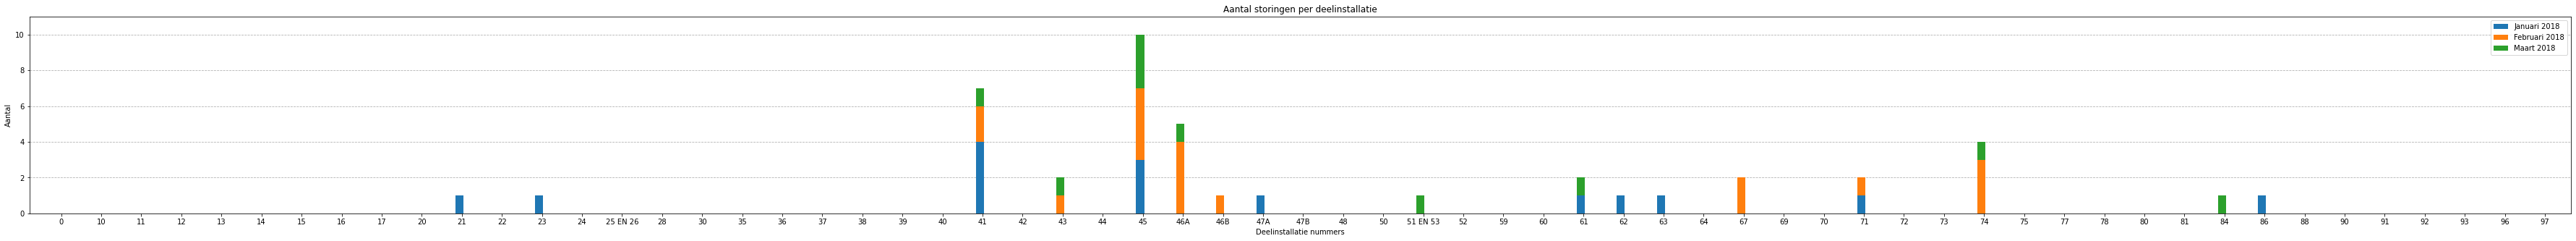

In [38]:
# prepping data
df = sf_data.copy()

input_data = (df, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = sa.prep(df, time_range, available_categories, time_key='rapport datum', category_key='sbs')

# plotting data
plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape
readable_labels = [sa.prettify_time_label(label) for label in sa.last_seen_bin_names]

sa.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=readable_labels)

01_2018 nan pop. count = 15
02_2018 nan pop. count = 27
03_2018 nan pop. count = 14


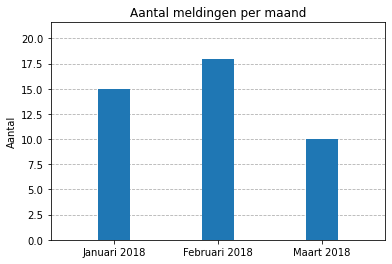

In [39]:
summary_data = sa.prep_summary(df, time_range, available_categories, time_key='rapport datum', category_key='sbs')
sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Aantal storingen per deelinstallatie

01_2018 nan pop. count = 2
02_2018 nan pop. count = 5
03_2018 nan pop. count = 2


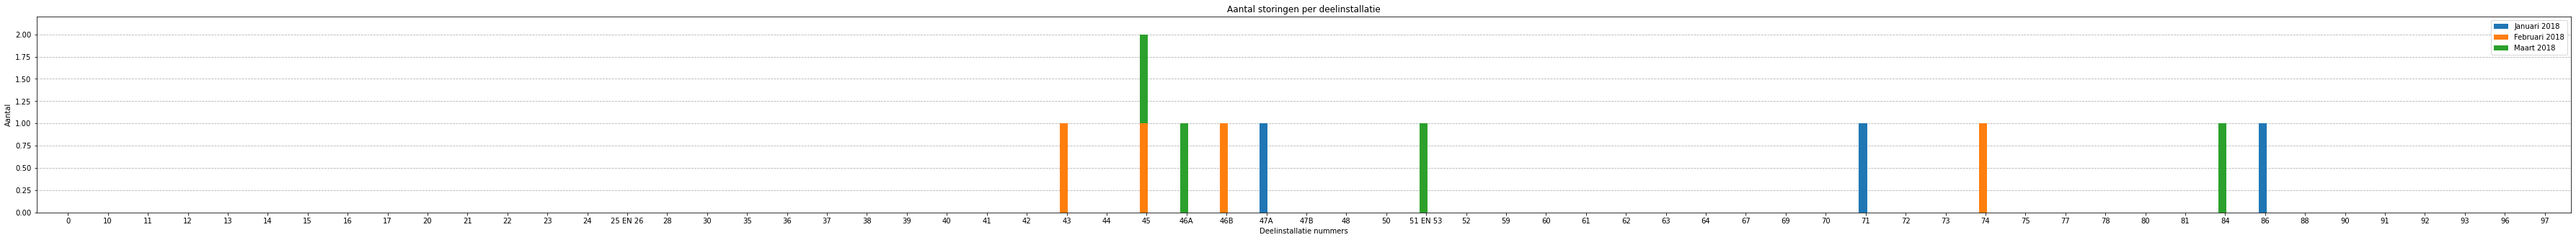

In [40]:
# prepping data
df_s = sa.storingen.copy()

input_data = (df_s, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = sa.prep(df_s, time_range, available_categories, time_key='rapport datum', category_key='sbs')

# plotting data
plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape
readable_labels = [sa.prettify_time_label(label) for label in sa.last_seen_bin_names]

sa.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=readable_labels)

01_2018 nan pop. count = 2
02_2018 nan pop. count = 5
03_2018 nan pop. count = 2


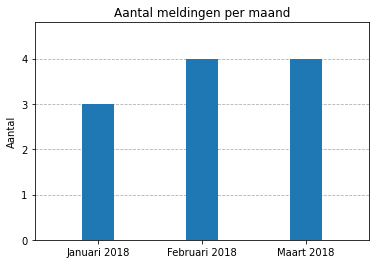

In [41]:
summary_data = sa.prep_summary(df_s, time_range, available_categories, time_key='rapport datum', category_key='sbs')
sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Aantal onterechte meldingen per deelinstallatie

01_2018 nan pop. count = 5
02_2018 nan pop. count = 6
03_2018 nan pop. count = 4


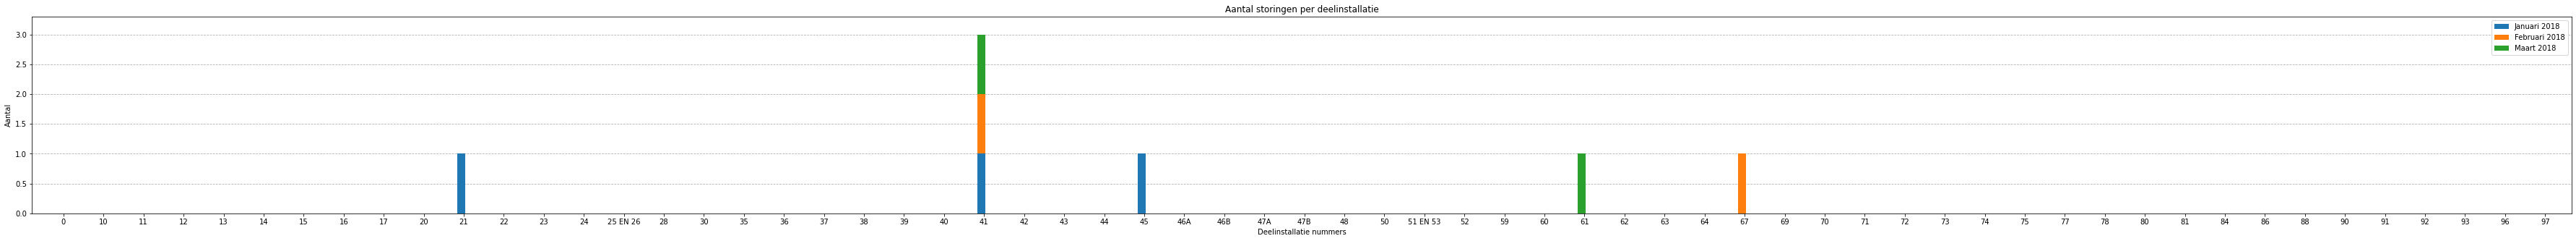

In [42]:
# prepping data
df_o = sa._isolate_notification_type(like_ntype='onterecht').copy()
input_data = (df_o, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = sa.prep(df_o, time_range, available_categories, time_key='rapport datum', category_key='sbs')

# plotting data
plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape
readable_labels = [sa.prettify_time_label(label) for label in sa.last_seen_bin_names]

sa.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=readable_labels)

01_2018 nan pop. count = 5
02_2018 nan pop. count = 6
03_2018 nan pop. count = 4


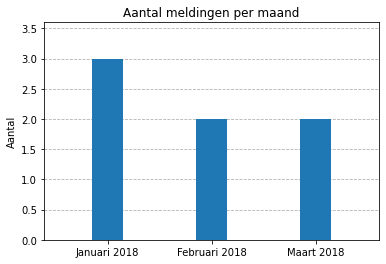

In [43]:
summary_data = sa.prep_summary(df_o, time_range, available_categories, time_key='rapport datum', category_key='sbs')
sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Totaal aantal meldingen preventief per deelinstallatie

01_2018 nan pop. count = 4
02_2018 nan pop. count = 6
03_2018 nan pop. count = 4


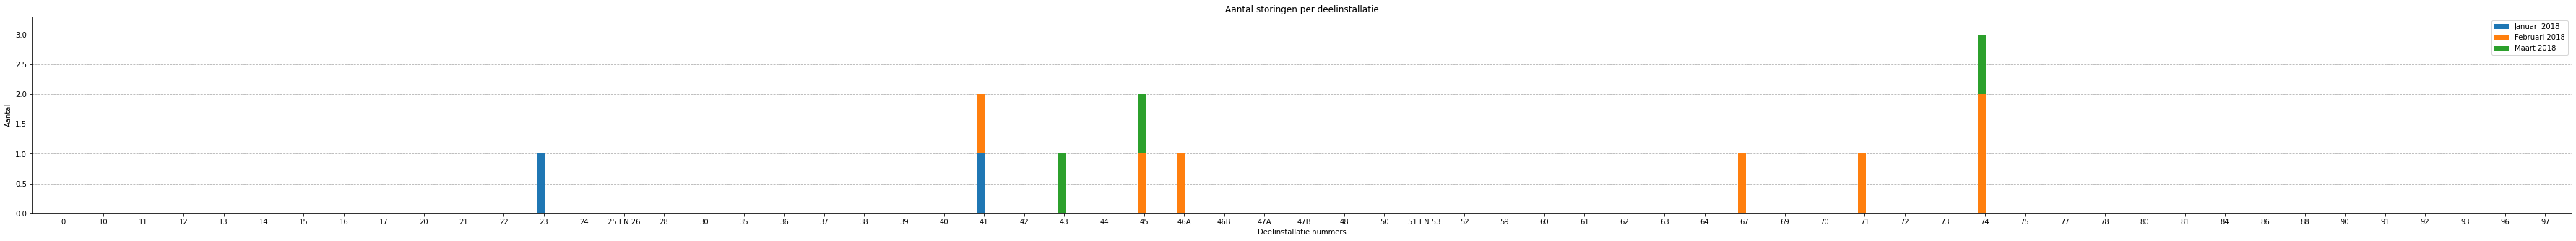

In [44]:
# prepping data
df_p = sa._isolate_notification_type(like_ntype='preventief').copy()
input_data = (df_p, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = sa.prep(df_p, time_range, available_categories, time_key='rapport datum', category_key='sbs')

# plotting data
plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape
readable_labels = [sa.prettify_time_label(label) for label in sa.last_seen_bin_names]

sa.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=readable_labels)

01_2018 nan pop. count = 4
02_2018 nan pop. count = 6
03_2018 nan pop. count = 4


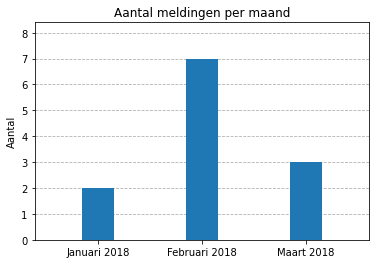

In [45]:
summary_data = sa.prep_summary(df_p, time_range, available_categories, time_key='rapport datum', category_key='sbs')
sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Aantal incidenten per deelinstallatie

01_2018 nan pop. count = 4
02_2018 nan pop. count = 10
03_2018 nan pop. count = 4


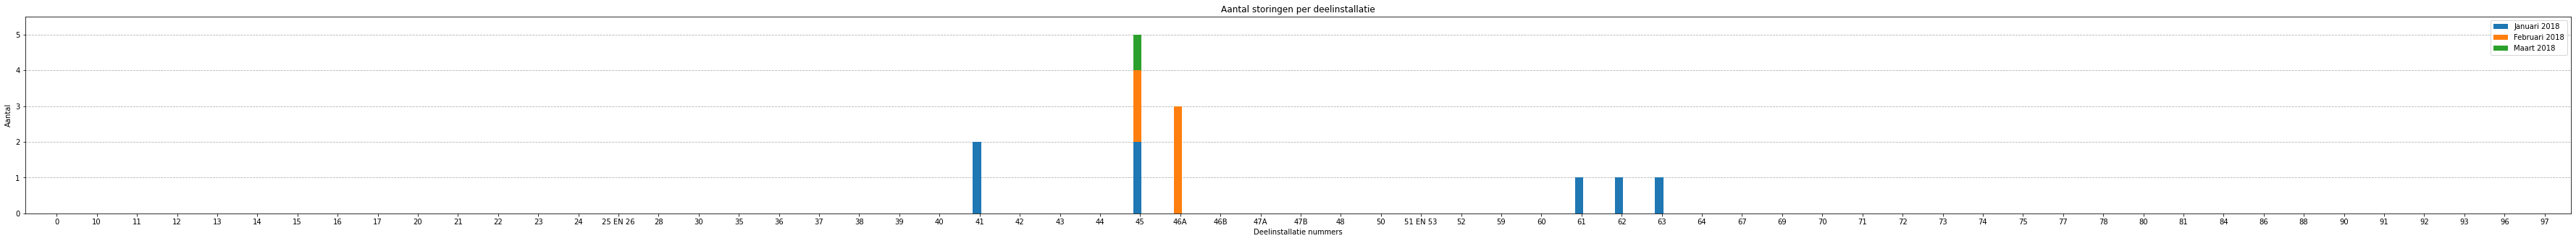

In [46]:
# prepping data
df_i = sa._isolate_notification_type(like_ntype='incident').copy()
input_data = (df_i, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = sa.prep(df_i, time_range, available_categories, time_key='rapport datum', category_key='sbs')

# plotting data
plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape
readable_labels = [sa.prettify_time_label(label) for label in sa.last_seen_bin_names]

sa.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=readable_labels)

01_2018 nan pop. count = 4
02_2018 nan pop. count = 10
03_2018 nan pop. count = 4


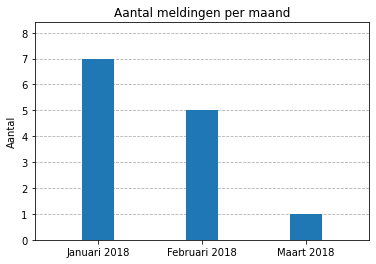

In [47]:
summary_data = sa.prep_summary(df_i, time_range, available_categories, time_key='rapport datum', category_key='sbs')
sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Vergelijking voorgaande kwartaal met huidinge kwartaal

### Meldingen

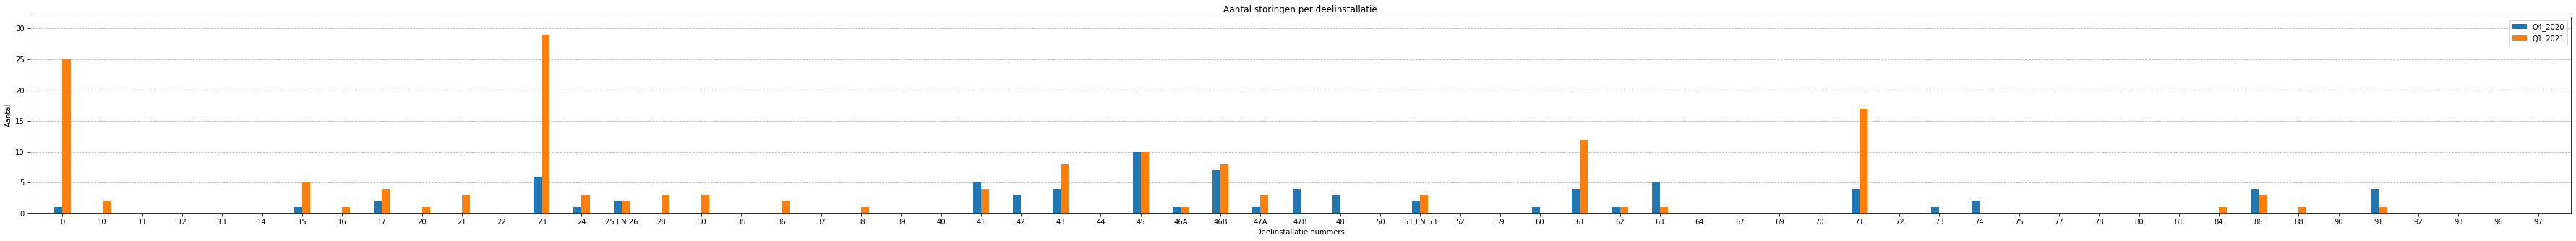

In [48]:
prepped_data = sa.prep(updated_meta_meldingen, 
                       time_range=['10-2020', '03-2021'], 
                       available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
                       time_key='rapport datum', 
                       category_key='sbs', 
                       bin_size='quarter')

sa.plot(input_data=prepped_data, 
        plot_type='side-by-side', 
        category_labels=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
        bin_labels=sa.last_seen_bin_names)

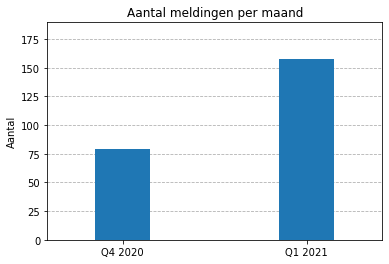

In [49]:
summary_data = sa.prep_summary(updated_meta_meldingen, 
                               time_range=['10-2020', '03-2021'], 
                               available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                               bin_size='quarter')

sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

### Storingen

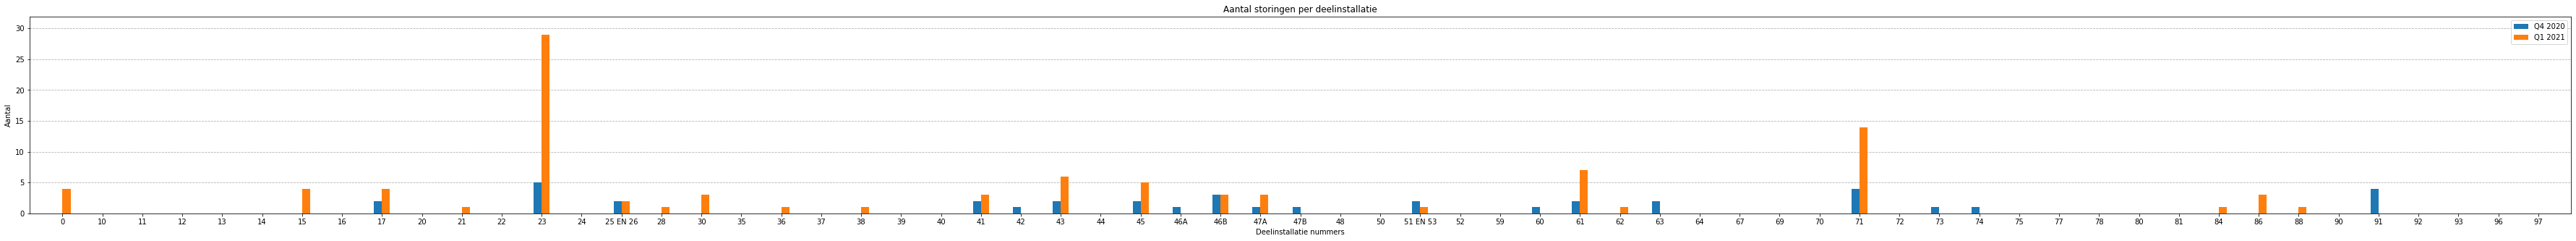

In [50]:
prepped_data = sa.prep(updated_meta_storingen, 
                       time_range=['10-2020', '03-2021'], 
                       available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
                       time_key='rapport datum', 
                       category_key='sbs', 
                       bin_size='quarter')

sa.plot(input_data=prepped_data, 
        plot_type='side-by-side', 
        category_labels=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
        bin_labels=[sa.prettify_time_label(label) for label in sa.last_seen_bin_names])

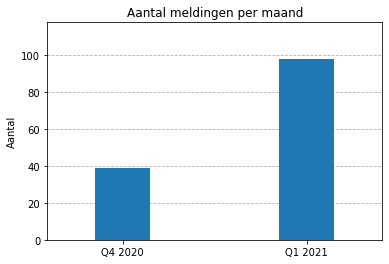

In [51]:
summary_data = sa.prep_summary(updated_meta_storingen, 
                               time_range=['10-2020', '03-2021'], 
                               available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                               bin_size='quarter')

sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], data=summary_data.values())

## Verdeling type meldingen per deelinstallatie

In [52]:
df = sa.meldingen.copy()

In [53]:
input_threshhold = widgets.IntSlider(
    value=0,
    min=0,
    max=sbs_count.max(),
    step=1,
    description='Drempelwaarde:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=dict(description_width='initial')
)

display(input_threshhold)

IntSlider(value=0, continuous_update=False, description='Drempelwaarde:', max=10, style=SliderStyle(descriptio…

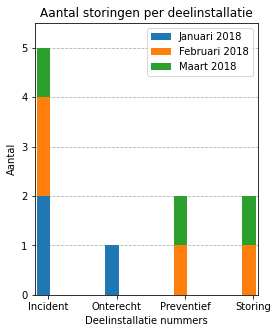

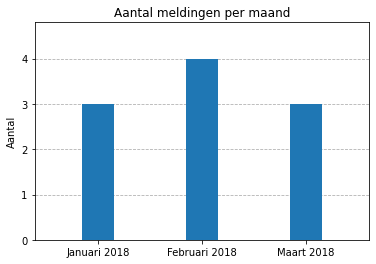

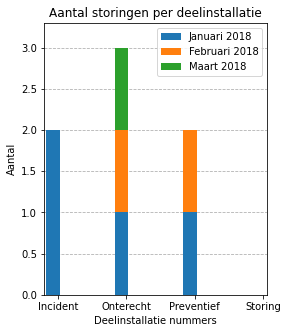

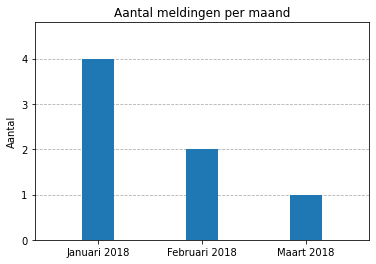

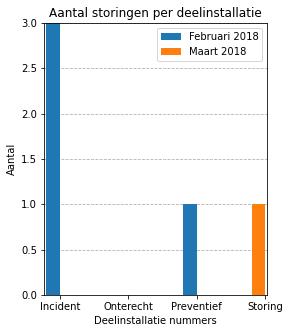

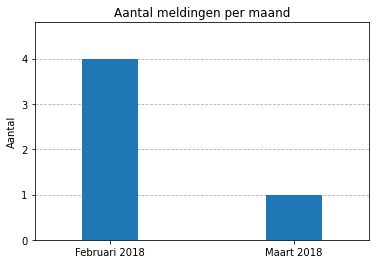

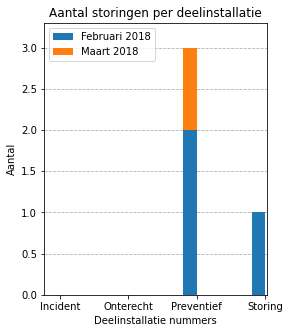

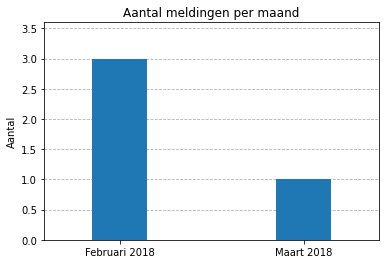

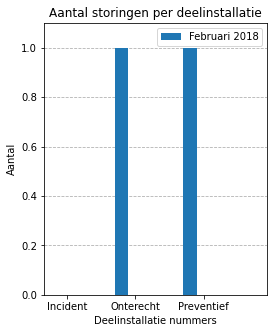

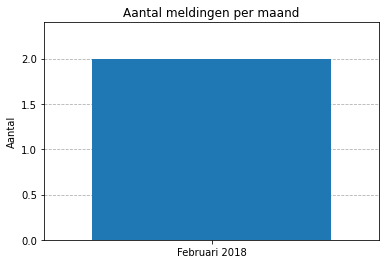

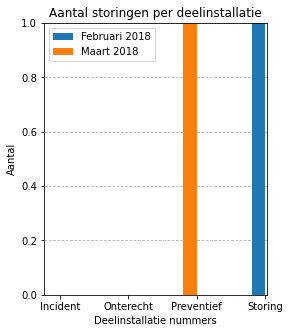

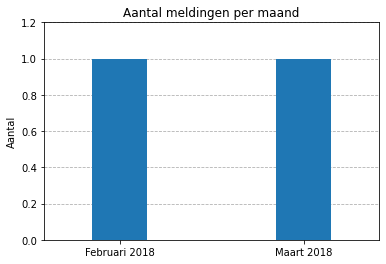

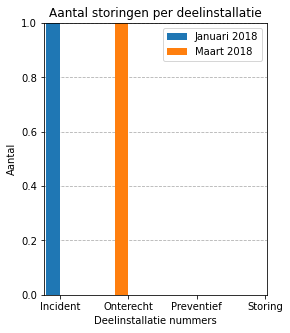

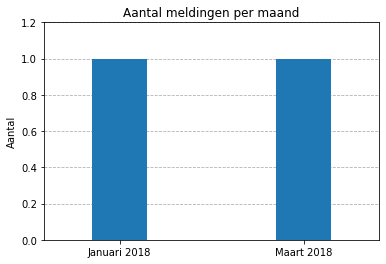

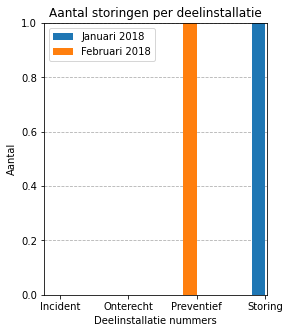

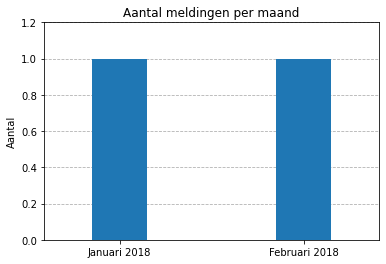

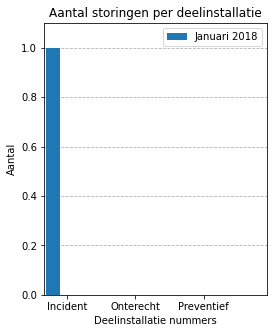

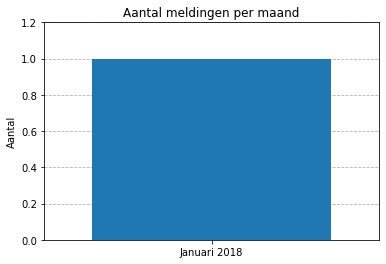

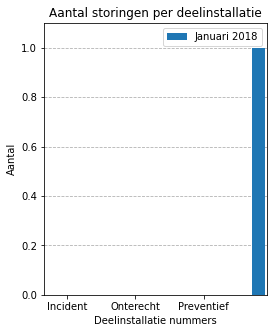

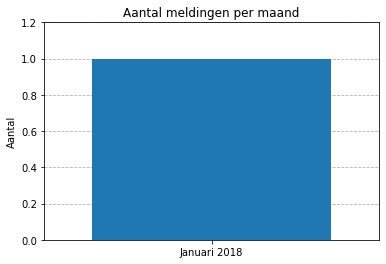

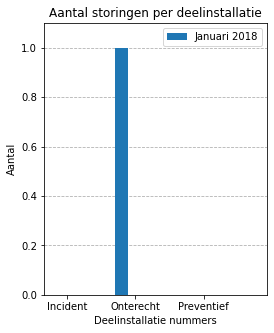

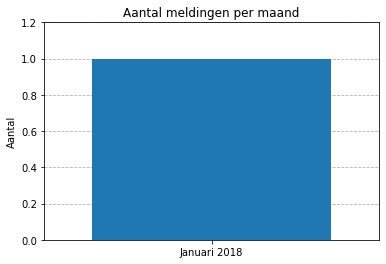

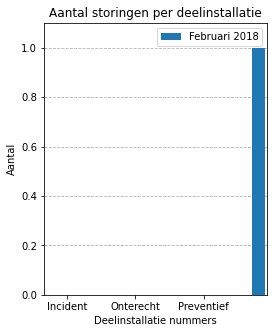

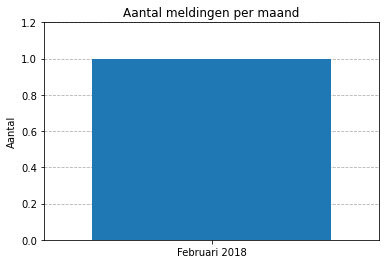

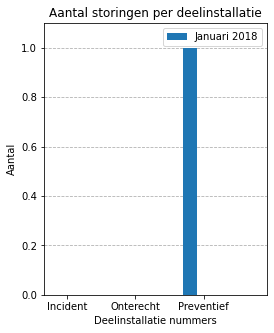

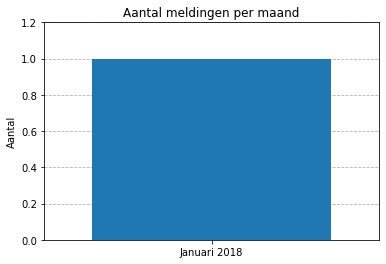

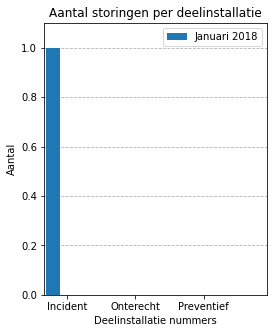

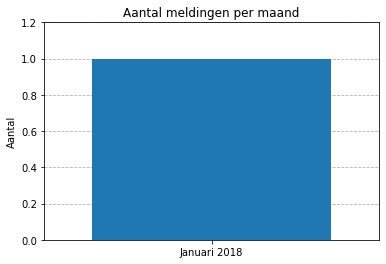

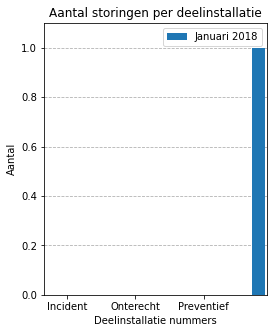

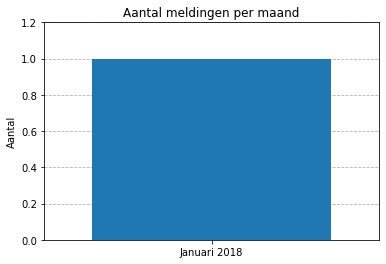

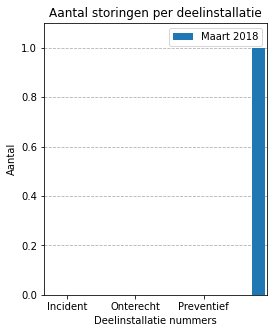

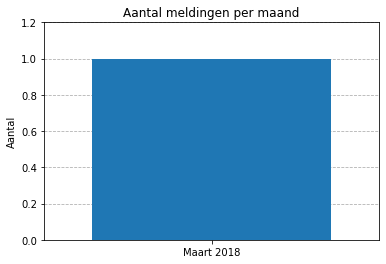

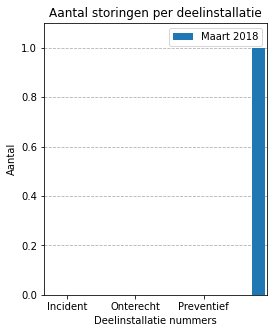

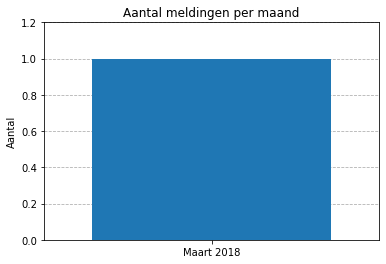

In [54]:
sbs_count = df.loc[:, 'sbs'].value_counts()
to_process = [x for x in sbs_count.index if sbs_count.at[x] >= input_threshhold.value]

df_groupby_sbs = df.groupby(['sbs'])

# unieke types vastlegen
unique_types = df.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'].unique()

# cols kan voor een sandbox tool variabel gemaakt worden.
cols = ['type melding (Storing/Incident/Preventief/Onterecht)', 'month_number']

for di_num in to_process:
    prepped_data = sa.prep(df_groupby_sbs.get_group(di_num), 
                           time_range=['10-2020', '03-2021'], 
                           available_categories=unique_types, 
                           time_key='rapport datum', 
                           category_key='type melding (Storing/Incident/Preventief/Onterecht)')
    
    sa.plot(input_data=prepped_data, 
            plot_type='stacked', 
            category_labels=unique_types, 
            bin_labels=[sa.prettify_time_label(label) for label in sa.last_seen_bin_names])
    
    summary_data = sa.prep_summary(df_groupby_sbs.get_group(di_num), 
                                   time_range=['10-2020', '03-2021'], 
                                   available_categories=unique_types, 
                                   time_key='rapport datum', 
                                   category_key='type melding (Storing/Incident/Preventief/Onterecht)')

    sa.plot_summary(x_labels=[sa.prettify_time_label(label) for label in summary_data.keys()], 
                    data=summary_data.values())

# Afronding
In de afronding worden de laatste handelingen van de automatisering uitgevoerd, zoals het opslaan van de geüpdatette historische data en het exporteren van de inhoud van dit Notebook naar een [pdf, docx] bestand.

In [55]:
updated_meta_meldingen, updated_meta_storingen, poo_from_meta

({'01_2016': {'45': 6,
   '61': 5,
   '23': 1,
   '43': 4,
   '41': 3,
   '46B': 3,
   '46A': 1,
   '44': 2,
   '97': 1,
   '21': 1,
   '48': 1,
   '15': 6,
   '74': 2,
   '36': 2,
   '59': 1,
   '50': 5,
   '67': 1,
   '40': 1,
   '90': 1,
   '92': 1},
  '02_2016': {'45': 19,
   '61': 4,
   '23': 13,
   '63': 4,
   '43': 1,
   '41': 7,
   '0': 3,
   '46B': 1,
   '46A': 1,
   '44': 7,
   '24': 1,
   '97': 1,
   '71': 8,
   '15': 6,
   '64': 1,
   '50': 2,
   '75': 1,
   '12': 1},
  '03_2016': {'45': 10,
   '61': 8,
   '63': 2,
   '43': 12,
   '41': 1,
   '0': 4,
   '46B': 1,
   '46A': 7,
   '24': 2,
   '21': 1,
   '71': 1,
   '86': 1,
   '64': 2,
   '59': 1,
   '67': 1,
   '80': 1},
  '04_2016': {'45': 6,
   '61': 4,
   '63': 3,
   '43': 12,
   '41': 3,
   '46B': 1,
   '46A': 2,
   '44': 2,
   '24': 4,
   '97': 4,
   '15': 1,
   '74': 1,
   '84': 1,
   '88': 1,
   '36': 1},
  '05_2016': {'45': 9,
   '61': 18,
   '63': 5,
   '43': 7,
   '41': 8,
   '0': 4,
   '46A': 1,
   '44': 1,
   '2

In [56]:
sa.export_graphs(filename='THIS IS THE TEST EXPORT OF THE REAL DEAL.pdf')